In [7]:
#Dependencies
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt


import utils.plotutils as plu
import utils.imreadin as imr

%matplotlib inline

In [20]:
#Model Parameters

tanh_model = 1 #0

#network params
compression = 2.6
patchsize = 16

#training params
batchsize = 100
iterations = 1000
epochs = 2

if(tanh_model):
    noisexsigma = 0
    noisersigma = 0
    minact = 0
    minslo = 0 
    learning_rate = 0.01
else:
    #noise
    noisexsigma = 0.01
    noisersigma = 0.5
    minact = 0.1 
    minslo = 0.1 
    learning_rate = 0.01

In [21]:
#Load in images if we haven't yet.

def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        #normalize=True,
        normalize_im = True,
        normalize_patch = False,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)

try:
    vhims
except NameError:
    vhims, loadedpatchsize = loadimages(patchsize)
    
if(patchsize != loadedpatchsize):
    vhims, loadedpatchsize = loadimages(patchsize)
       
print("Images Loaded.")

#params of images
imxlen = len(vhims.images[0,0,:])
imylen = len(vhims.images[0,:,0])
nimages = len(vhims.images[:,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
else:
    print('Training',nimstrained,'out of',nimages,'total image patches.')

Images Loaded.
Training 100000 out of 4685824 total image patches.


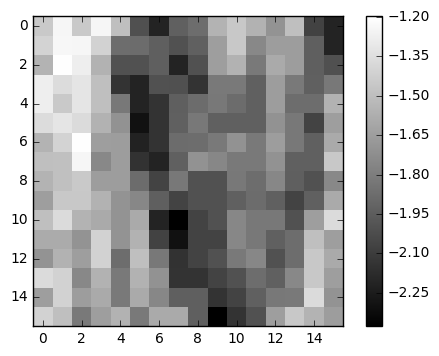

In [22]:
#show an example image
plt.imshow(vhims.images[100],cmap='gray',interpolation='none')
plt.colorbar()

In [23]:
nneurons = np.int(imxlen*imylen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')

#input image
x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen),name='input_image')
#output image
#xp = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen),name='output_image')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=0.1),name='weights_in')
#wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')
#wout = tf.placeholder(tf.float32, shape=np.shape(win),name='weights_out')
#bias
bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.1),name='bias')

#calculate inner layer
linear = tf.add(tf.matmul(tf.add(x,nx),win),bias)

#tanh or sigmoid?
model_tanh = tf.placeholder(tf.int32, shape=[], name="model_tanh")
y = tf.cond(model_tanh > 0, lambda: tf.nn.tanh(linear), lambda: tf.nn.sigmoid(linear))
##y = tf.nn.sigmoid(tf.add(tf.matmul(tf.add(x,nx),win),bias))
##y = tf.nn.tanh(tf.add(tf.matmul(tf.add(x,nx),win),bias))

#calculate ouer layer
wout = tf.transpose(win)
xp = tf.add(tf.nn.sigmoid(tf.matmul(y,wout)),nr)
#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Compressing by 2.6 for a total of 98 neurons


In [ ]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    y_evolution = []
    
    images = []
    recons = []
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(vhims.images)
        for ii in range(nits):
            image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).astype(np.float32)
            #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
            #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
            sess.run(train_step, feed_dict={x:image, model_tanh:tanh_model})

            #save evolution of params
            objcost, yr = sess.run([cost,y], feed_dict={x:image, model_tanh:tanh_model})
            cost_evolution.append(objcost)
            y_evolution.append(np.mean(yr))
            
            if(ii%(int((nits)/10))==0):
                print(str(ii)+', ',end="")
                #and save our image and reconstruction
                images.append(np.reshape(image,[batchsize,imxlen,imylen]))
                recons.append(np.reshape(sess.run(xp, feed_dict={x:image, model_tanh:tanh_model}),[batchsize,imxlen,imylen]))
    
    
    weights = sess.run(win, feed_dict={x:image, model_tanh:tanh_model})
    print('\nDone!')

Training 1000 iterations in 2 epochs...

Epoch 1: 


In [ ]:
#Show our weights
wr = np.rollaxis(np.reshape(weights,(imxlen,imylen,nneurons)),2)
plu.display_data_tiled(wr, normalize=False, title="weights", prev_fig=None)

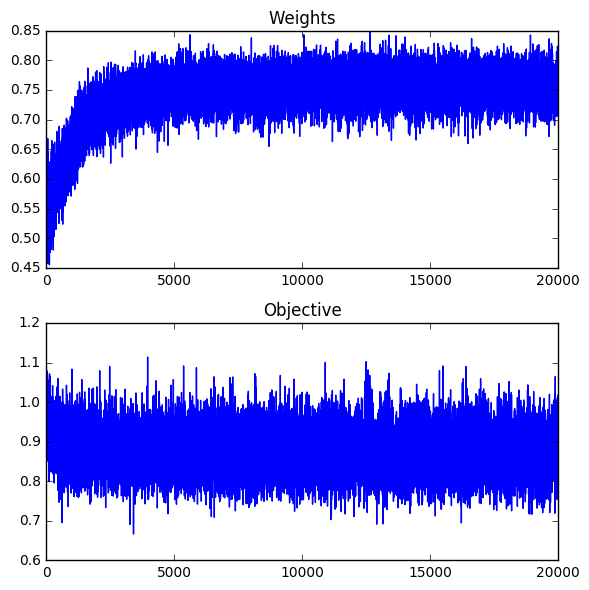

In [8]:
plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(y_evolution)

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

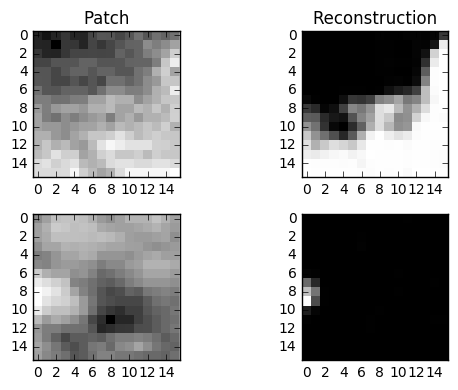

In [9]:
#show an example image and reconstruction from the last iteration of learning
patchnum = 6

#one example
plt.subplot(2,2,1,title='Patch')
plt.imshow(images[-1][patchnum],cmap='gray',interpolation='none')
plt.subplot(2,2,2,title='Reconstruction')
plt.imshow(recons[-1][patchnum],cmap='gray',interpolation='none')

#another
plt.subplot(2,2,3)
plt.imshow(images[-1][patchnum+1],cmap='gray',interpolation='none')
plt.subplot(2,2,4)
plt.imshow(recons[-1][patchnum+1],cmap='gray',interpolation='none')

plt.tight_layout()

code to plot the tiling of on and off RFs - for now opencv isn't working

In [54]:
from sklearn import mixture

def fit_circs(samples):
    gmix = mixture.GaussianMixture(n_components=1, covariance_type='full')
    gmix = gmix.fit(samples)
    return(gmix.reshape(1,-1))

def plotonoff(allws):
    
    allws = weights
    #get on center
    onws = np.mean(allws,axis=0)>0
    onws = allws[:,onws]
    #get off center
    offws = np.mean(allws,axis=0)<0
    offws = allws[:,offws]
    #keep track of the circles
    oncircs = []
    offcircs = []

    #blank 16x16 to draw circles
    onrfs = np.zeros_like(weights[0])
    offrfs = np.zeros_like(weights[0])

    #on cells

    for on in onws:
        #circs = cv2.HoughCircles(on,cv2.CV_HOUGH_GRADIENT)
        #circs = cv2.HoughCircles(on, oncircs, cv2.CV_HOUGH_GRADIENT,
                           #dp=1.5, minDist=30, minRadius=3, maxRadius=10)
        #cv2.circle(onrfs,((circ[0,0],i[0,1]),i[0,2],(0,255,0),2))
        oncircs.append(fit_circs(on))

    #off cells
    for off in offws:
        #circs = cv2.HoughCircles(off, offcircs, cv2.CV_HOUGH_GRADIENT,
        #                   dp=1.5, minDist=30, minRadius=3, maxRadius=10)
        #cv2.circle(offrfs,((circ[0,0],i[0,1]),i[0,2],(0,255,0),2))
        offcircs.append(fit_circs(off))

    print(oncircs[0])
        
    #plot
    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1,title='On')
    #for onc in oncircs:
    #    plt.contour(np.linspace(0,,onrfs[1],onc)
        
    plt.subplot(1,2,2,title='Off')
    #plt.imshow(offrfs)

    plt.tight_layout()
    

In [55]:
plotonoff(weights)

/home/vasha/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


AttributeError: 'GaussianMixture' object has no attribute 'reshape'

In [ ]:
print(weights[1])

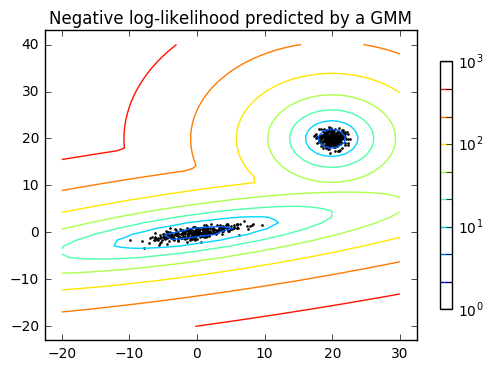

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

## Autoencoder Math

